

# AUTOENCODER

Fuente: https://github.com/syorami/Autoencoders-Variants






#### Funciones a usar


In [1]:

import warnings
warnings.filterwarnings('ignore')
import os, datetime
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torchvision
# import data_utils
import matplotlib.pyplot as plt

from torch import nn
from torch.autograd import Variable


# de la data_utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils import data


# funciones

def load_mnist(BATCH_SIZE=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    print(f'Train Data Shape: {trainset.train_data.numpy().shape}')
    print(f'Test Data Shape: {testset.test_data.numpy().shape}')

    return trainloader, testloader


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
BATCH_SIZE = 128
train_loader, test_loader = load_mnist(BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 53516327.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1783663.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12120257.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7700294.57it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)


#### elegir ruta para guardar / cargar el modelo entrenado

In [11]:
# una ruta del drive...
direccion = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_7/autoencoder'

In [3]:
# esta ruta es el colab mismo.. al cerrar la sesion se pierden los archivos
direccion = '/content'

In [4]:
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

In [5]:
def model_training(autoencoder, train_loader, epoch, L1_loss = False):
    loss_metric = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        # calculo de loss
        mse_loss = loss_metric(outputs, images)
        if L1_loss:
            l1_loss = sparse_loss(autoencoder, images)
            loss = mse_loss + SPARSE_REG * l1_loss # <---------------------------------------------------- A C A !
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        if (i + 1) % LOG_INTERVAL == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader.dataset) // BATCH_SIZE, loss.item()
            ))


def evaluation(autoencoder, test_loader, model_name, L1_loss = False):
    total_loss = 0
    loss_metric = nn.MSELoss()
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images, _ = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        # calculo de loss
        mse_loss = loss_metric(outputs, images)
        if L1_loss:
            l1_loss = sparse_loss(autoencoder, images)
            loss = mse_loss + SPARSE_REG * l1_loss # <---------------------------------------------------- A C A !
        else:
            loss = mse_loss

        total_loss += loss * len(images)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))

    global BEST_VAL
    if TRAIN_SCRATCH and avg_loss < BEST_VAL:
        BEST_VAL = avg_loss
        torch.save(autoencoder.state_dict(), os.path.join(direccion, model_name + ".pt"))
        print('Save Best Model in HISTORY\n')


### SIMPLE AUTOENCODER

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2),
            #nn.ReLU(inplace=True)
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Tanh()
            #nn.ReLU()
        )

    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x




In [18]:
autoencoder = Autoencoder()
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=2, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


Average MSE Loss on Test set: 0.1516


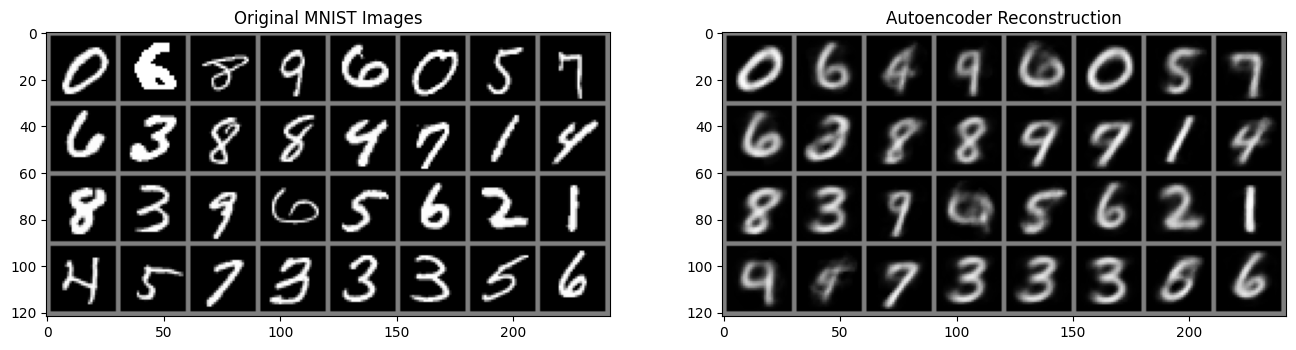

In [19]:
EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
SPARSE_REG = 1e-3
LOG_INTERVAL = 100
TRAIN_SCRATCH = False  # whether to train a model from scratch
BEST_VAL = float('inf')     # record the best val loss
MODEL_NAME = 'simple_autoencoder_2d_tanh_50'



if cuda: autoencoder.to(device)

if TRAIN_SCRATCH:
    # Training autoencoder from scratch
    for epoch in range(EPOCHS):
        starttime = datetime.datetime.now()
        model_training(autoencoder, train_loader, epoch)
        endtime = datetime.datetime.now()
        print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
        # evaluate on test set and save best model
        evaluation(autoencoder, test_loader, MODEL_NAME)
    print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

else:

    autoencoder.load_state_dict(torch.load(os.path.join(direccion, MODEL_NAME + ".pt"), map_location = device))

    evaluation(autoencoder, test_loader, MODEL_NAME)

    autoencoder.cpu()
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    images = Variable(images[:32])
    outputs = autoencoder(images.view(images.size(0), -1))

    # plot and save original and reconstruction images for comparisons
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.title('Original MNIST Images')
    imshow(torchvision.utils.make_grid(images))
    plt.subplot(122)
    plt.title('Autoencoder Reconstruction')
    imshow(torchvision.utils.make_grid(
        outputs.view(images.size(0), 1, 28, 28).data
        ))
    plt.savefig(os.path.join(direccion, "simple_autoencoder.png"))

### CONVOLUTIONAL AUTOENCODER


In [12]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # sale [batch, 16, 28, 28]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),# sale [batch, 16, 14, 14]
            nn.Conv2d(16, 8, 3, padding=1),# sale [batch, 8, 14, 14]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)# sale [batch, 8, 7, 7]
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),# sale [batch, 8, 7, 7]
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),# sale [batch, 8, 14, 14]
            nn.Conv2d(8, 16, 3, padding=1),# sale [batch, 16, 14, 14]
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2), # sale [batch, 16, 28, 28]
            nn.Conv2d(16, 1, 3, padding=1),# sale [batch, 1, 28, 28]
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        h = self.encoder(x)
        x = self.decoder(h)
        x = x.view(x.size(0), -1)
        return x


In [13]:
conv_autoencoder = ConvAutoencoder()


Average MSE Loss on Test set: 0.0213


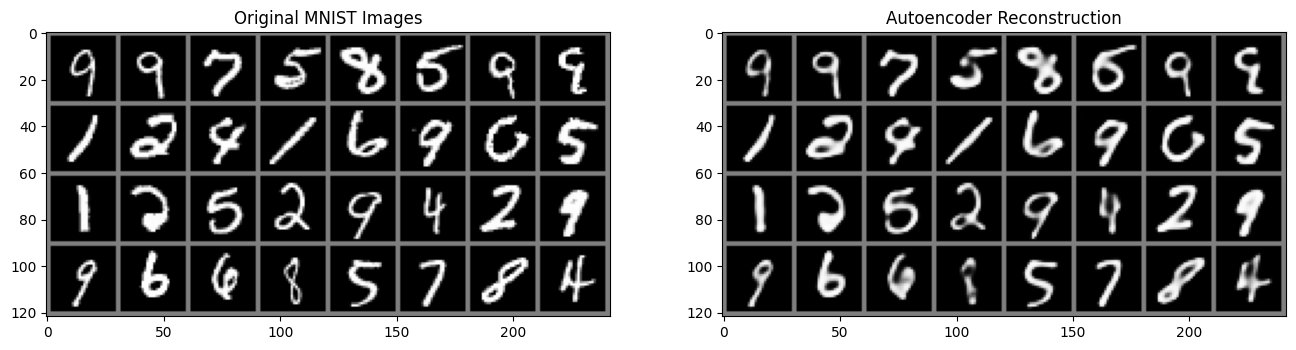

In [14]:
EPOCHS = 5
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
SPARSE_REG = 1e-3
LOG_INTERVAL = 100
TRAIN_SCRATCH = False       # whether to train a model from scratch
BEST_VAL = float('inf')     # record the best val loss
MODEL_NAME = 'conv_autoencoder_100'



if cuda: conv_autoencoder.to(device)

if TRAIN_SCRATCH:
    for epoch in range(EPOCHS):
        starttime = datetime.datetime.now()
        model_training(conv_autoencoder, train_loader, epoch)
        endtime = datetime.datetime.now()
        print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
        # evaluate on test set and save best model
        evaluation(conv_autoencoder, test_loader, MODEL_NAME)
    print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))
else:

    conv_autoencoder.load_state_dict(torch.load(os.path.join(direccion, MODEL_NAME + ".pt"), map_location=device))

    evaluation(conv_autoencoder, test_loader, MODEL_NAME)

    conv_autoencoder.cpu()
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    images = Variable(images[:32])
    outputs = conv_autoencoder(images)

    # plot and save original and reconstruction images for comparisons
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.title('Original MNIST Images')
    imshow(torchvision.utils.make_grid(images))
    plt.subplot(122)
    plt.title('Autoencoder Reconstruction')
    imshow(torchvision.utils.make_grid(
            outputs.view(images.size(0), 1, 28, 28).data))
    plt.savefig(os.path.join(direccion, 'conv_autoencoder.png'))

### SPARSE AUTOENCODER L1


In [15]:
class SparseAutoencoderL1(nn.Module):
    def __init__(self):
        super(SparseAutoencoderL1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(3):
        fc_layer = list(autoencoder.encoder.children())[2 * i]
        relu = list(autoencoder.encoder.children())[2 * i + 1]
        values = relu(fc_layer(values))
        loss += torch.mean(torch.abs(values))
    for i in range(2):
        fc_layer = list(autoencoder.decoder.children())[2 * i]
        relu = list(autoencoder.decoder.children())[2 * i + 1]
        values = relu(fc_layer(values))
        loss += torch.mean(torch.abs(values))
    return loss




In [16]:
autoencoder = SparseAutoencoderL1()
autoencoder

SparseAutoencoderL1(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


Average MSE Loss on Test set: 0.0350


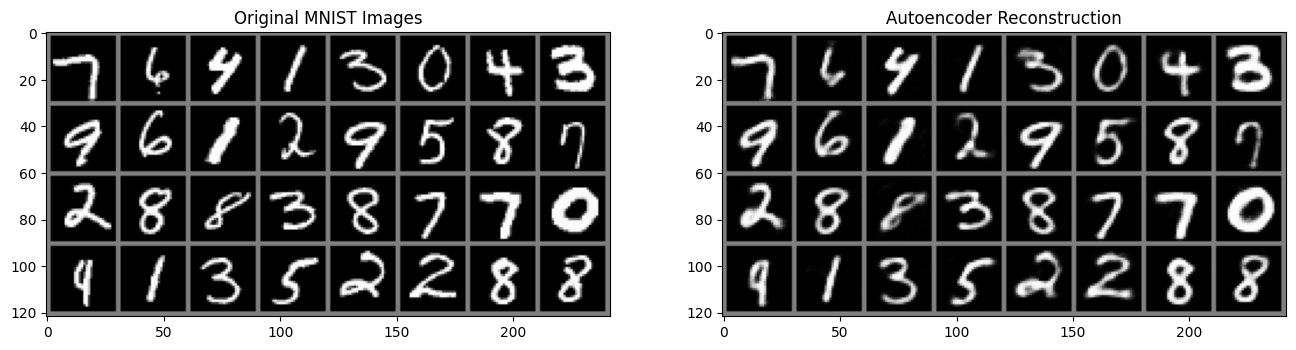

In [17]:
EPOCHS = 3
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
LOG_INTERVAL = 100
SPARSE_REG = 1e-3
TRAIN_SCRATCH = False       # whether to train a model from scratch
BEST_VAL = float('inf')     # record the best val loss
MODEL_NAME = 'sparse_autoencoder_l1_100'


if cuda: autoencoder.to(device)

if TRAIN_SCRATCH:
    # Training autoencoder from scratch
    for epoch in range(EPOCHS):
        starttime = datetime.datetime.now()
        model_training(autoencoder, train_loader, epoch, L1_loss = True)
        endtime = datetime.datetime.now()
        print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
        # evaluate on test set and save best model
        evaluation(autoencoder, test_loader, MODEL_NAME, L1_loss = True)
        print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

else:
    autoencoder.load_state_dict(torch.load(os.path.join(direccion, MODEL_NAME + ".pt"), map_location = device))
    evaluation(autoencoder, test_loader, MODEL_NAME, L1_loss = True)
    autoencoder.cpu()
    dataiter = iter(train_loader)
    images, _ = next(dataiter)
    images = Variable(images[:32])
    outputs = autoencoder(images.view(images.size(0), -1))
    # plot and save original and reconstruction images for comparisons
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.title('Original MNIST Images')
    imshow(torchvision.utils.make_grid(images))
    plt.subplot(122)
    plt.title('Autoencoder Reconstruction')
    imshow(torchvision.utils.make_grid(
            outputs.view(images.size(0), 1, 28, 28).data
    ))

    plt.savefig(os.path.join(direccion, "sparse_autoencoder_l1.png"))

## grafico 3D


In [ ]:
# estamos generando un nuevo model, que copia el sequential del model original, la parte del encoder
pepe = autoencoder.encoder
pepe.load_state_dict(autoencoder.encoder.state_dict())

<All keys matched successfully>

In [ ]:
pepe.to('cpu')

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=4, bias=True)
  (5): Sigmoid()
)

In [ ]:
# mapeo el laten space del test
# le pasamos un batch del TEST set y plotemaos la codificación del mismo
img, label = next(iter(test_loader))

# acá le pasamos TODO el batch del TEST al ENCODER, en las dimensiones adecuadas (las
# imagenes de 28x28 son vectorizadas).

latent = pepe(img.view(img.size(0), -1))
# vemos el tamaño de lo que obtuvimos
print('           batch x size')
latent.shape

           batch x size


torch.Size([128, 4])

In [ ]:
label.shape

torch.Size([128])

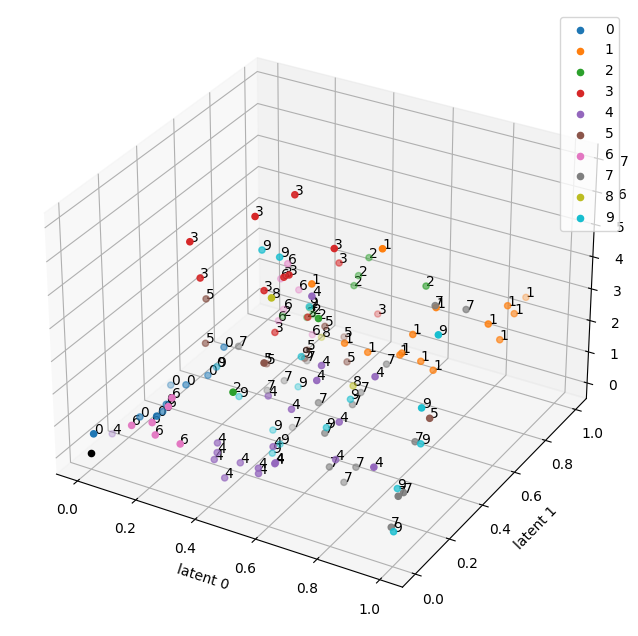

In [ ]:
# para graficar un embedding de dimensión 3
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(projection='3d')

# obtenemos las coordenadas de cada cifra (codificación del encoder)
x_l, y_l, z_l = latent[:,0].detach().numpy(), latent[:,1].detach().numpy(), latent[:,2].detach().numpy()

# graficamos cada cifra en su espacio latente
color = label.detach().numpy()

for k in range(10):
  ax.scatter(x_l[color==k], y_l[color==k], z_l[color==k])



# Etiquetamos cada punto para mayor claridad
texts = [ax.text(x_l[i], y_l[i], z_l[i], txt) for i,
     txt in enumerate(label.detach().numpy())]

ax.scatter(0, 0, 0, c='black')
ax.legend(range(10))

# ejes
plt.xlabel('latent 0')
plt.ylabel('latent 1')
ax.set_zlabel('latent 2')


plt.show()

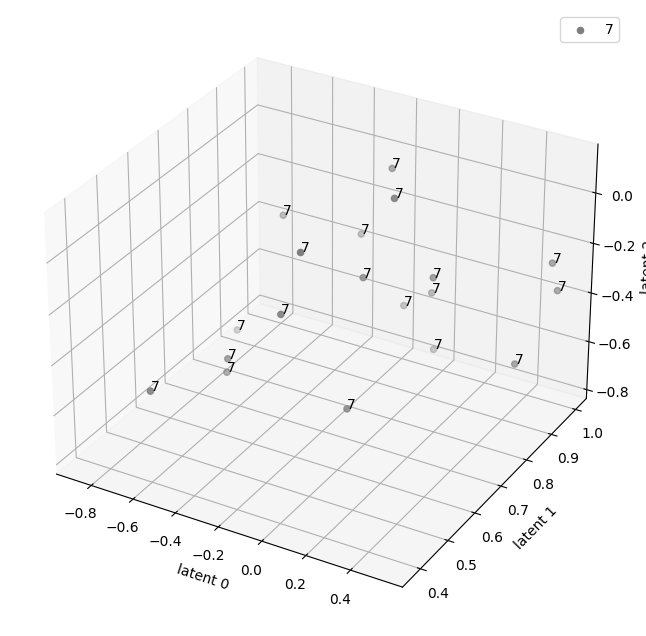

In [ ]:
# para graficar un embedding de dimensión 3


fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(projection='3d')

# obtenemos las coordenadas de cada cifra (codificación del encoder)
x_l, y_l, z_l = latent[:,0].detach().numpy(), latent[:,1].detach().numpy(), latent[:,2].detach().numpy()
lab = label.detach().numpy()
# graficamos cada cifra en su espacio latente


col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
    'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

k = 7
ax.scatter(x_l[lab==k], y_l[lab==k], z_l[lab==k], c=col[k])
  #ax.text(x_l[lab==k], y_l[lab==k], z_l[lab==k], lab[lab==k])


# Etiquetamos cada punto para mayor claridad
texts = [ax.text(x_l[lab==k][i], y_l[lab==k][i], z_l[lab==k][i], txt) for i,
     txt in enumerate(lab[lab==k])]


ax.legend(str(k))

# ejes
plt.xlabel('latent 0')
plt.ylabel('latent 1')
ax.set_zlabel('latent 2')


plt.show()

## grafico 2d

In [20]:
# estamos generando un nuevo model, que copia el sequential del model original, la parte del encoder
pepe = autoencoder.encoder
pepe.load_state_dict(autoencoder.encoder.state_dict())

<All keys matched successfully>

In [21]:
pepe.to('cpu')

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Tanh()
)

In [22]:
# mapeo el laten space del test
# le pasamos un batch del TEST set y plotemaos la codificación del mismo
img, label = next(iter(test_loader))

# acá le pasamos TODO el batch del TEST al ENCODER, en las dimensiones adecuadas (las
# imagenes de 28x28 son vectorizadas).

latent = pepe(img.view(img.size(0), -1))
# vemos el tamaño de lo que obtuvimos
print('           batch x size')
latent.shape

           batch x size


torch.Size([128, 2])

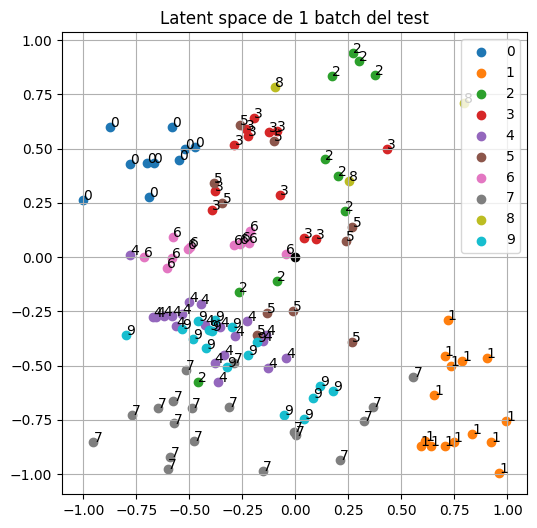

In [23]:
# ploteamos los resultados
fig, ax = plt.subplots(figsize=(6, 6))
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
    'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# obtenemos las coordenadas de cada cifra (codificación del encoder)
x_l, y_l= latent[:,0].detach().numpy(), latent[:,1].detach().numpy()


# graficamos cada cifra en su espacio latente
color = label.detach().numpy()

for k in range(10):
  ax.scatter(x_l[color==k], y_l[color==k], c=col[k])

# Etiquetamos cada punto para mayor claridad
texts = [ax.text(latent[i,0], latent[i,1], txt.item()) for i,
      txt in enumerate(label)]

ax.scatter(0, 0, c='black')
ax.legend(range(10))
plt.title('Latent space de 1 batch del test')

plt.grid()
plt.show()
